# Slow-waves detection

This notebook demonstrates how to use YASA to automatically detect slow waves on single-channel EEG.

Please make sure to install YASA first by typing the following line in your terminal or command prompt:

`pip install --upgrade yasa`

In [1]:
import yasa
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mne.filter import filter_data
sns.set(font_scale=1.2)

## Data loading and filtering

As an example, we load 60 seconds of N3 sleep on a single channel frontal EEG data sampled at 100 Hz.

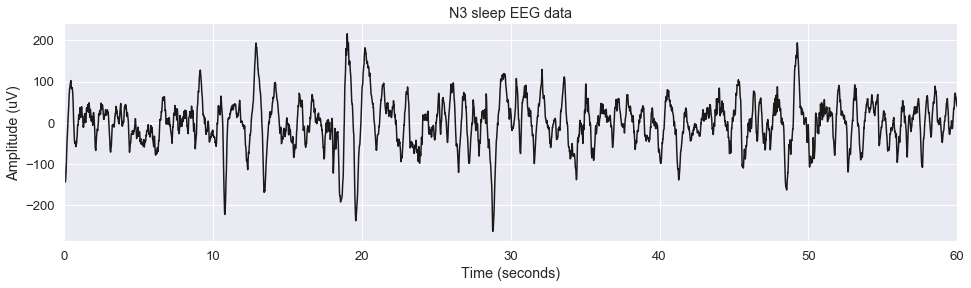

In [2]:
# Load data
data = np.load('data_full_6hrs_100Hz_Cz+Fz+Pz.npz').get('data')
ch_names = ['Cz', 'Fz', 'Pz']
hypno = np.load('data_full_6hrs_100Hz_hypno.npz').get('hypno')

# Keep only Fz and during a N3 sleep period with (huge) slow-waves
data = data[1, 666000:672000].astype(np.float64)
hypno = hypno[666000:672000]

# Define sampling frequency and time vector
sf = 100.
times = np.arange(data.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(times, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([times.min(), times.max()])
plt.title('N3 sleep EEG data')
sns.despine()

Setting up band-pass filter from 0.3 - 3.5 Hz
Filter length of 1651 samples (16.510 sec) selected
Using filter length: 1651
Smart-padding with:  1650 samples on each edge
FFT block length:   4096


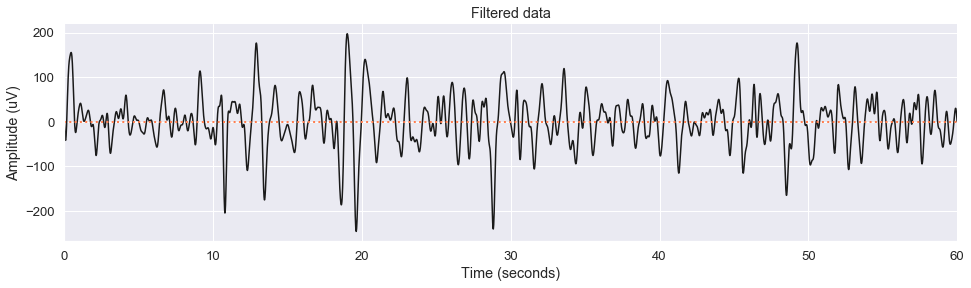

In [3]:
# Slow-waves FIR bandpass filter
freq_sw = (0.3, 3.5)
data_filt = filter_data(data, sf, freq_sw[0], freq_sw[1], method='fir', verbose=1, 
                        l_trans_bandwidth=0.2, h_trans_bandwidth=0.2)

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(times, data_filt, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([times.min(), times.max()])
plt.axhline(0, color='coral', ls=':', lw=2)
plt.title('Filtered data')
sns.despine()

In [4]:
from yasa import sw_detect

# Short version
# sw = sw_detect(data, sf, hypno=hypno)

# Long version (with all the optional arguments)
sw = sw_detect(data, sf, hypno=hypno, freq_sw=(0.3, 3.5), dur_neg=(0.3, 1.5),
               dur_pos=(0.1, 1), amp_neg=(40, 300), amp_pos=(10, 150),
               amp_ptp=(75, 400), downsample=True, remove_outliers=False)

sw.round(2)

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Stage
0,1.75,2.14,2.35,2.55,2.64,0.89,-75.69,14.21,89.90,428.09,1.12,3
1,2.94,3.10,3.36,3.50,4.29,1.35,-70.86,22.57,93.43,359.33,0.74,3
2,5.88,6.22,6.40,6.67,7.08,1.20,-57.00,71.33,128.33,712.92,0.83,3
3,9.40,10.15,10.26,10.39,10.63,1.23,-51.74,34.50,86.24,783.96,0.81,3
4,10.63,10.79,10.97,11.04,11.90,1.27,-204.70,23.72,228.42,1268.99,0.79,3
5,11.90,12.30,12.58,14.16,14.42,2.52,-109.28,81.39,190.67,680.97,0.40,3
6,13.26,13.45,13.78,14.16,14.42,1.16,-175.33,81.39,256.72,777.95,0.86,3
7,17.96,18.12,18.28,20.21,20.75,2.79,-60.16,139.78,199.94,1249.61,0.36,3
8,18.30,18.61,18.80,20.21,20.75,2.45,-186.34,139.78,326.11,1716.39,0.41,3
9,19.39,19.61,19.95,20.21,20.75,1.36,-245.96,139.78,385.74,1134.52,0.74,3


In [5]:
# Let's get a bool vector indicating for each sample
bool_sw = yasa.get_bool_vector(data, sf, sw)
bool_sw

array([0, 0, 0, ..., 1, 1, 0])

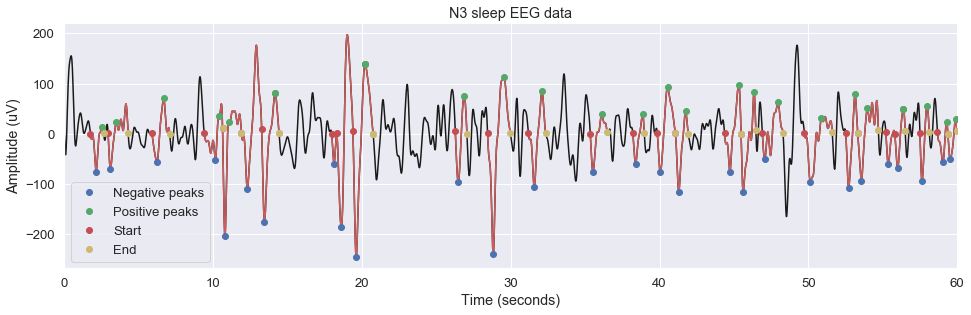

In [6]:
sw_highlight = data_filt * bool_sw
sw_highlight[sw_highlight == 0] = np.nan

plt.figure(figsize=(16, 4.5))
plt.plot(times, data_filt, 'k')
plt.plot(times, sw_highlight, 'indianred')
plt.plot(sw['NegPeak'], sw['ValNegPeak'], 'bo', label='Negative peaks')
plt.plot(sw['PosPeak'], sw['ValPosPeak'], 'go', label='Positive peaks')
plt.plot(sw['Start'], data_filt[(sw['Start'] * sf).astype(int)], 'ro', label='Start')
plt.plot(sw['End'], data_filt[(sw['End'] * sf).astype(int)], 'yo', label='End')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([0, times[-1]])
plt.title('N3 sleep EEG data')
plt.legend()
sns.despine()

In [7]:
%timeit sw_detect(data, sf)

95 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**************************

## Step-by-step

In [8]:
from scipy.signal import find_peaks

# Negative peaks with value comprised between -40 to -300 uV
idx_neg_peaks, _ = find_peaks(-1 * data_filt, height=(40, 300))

# Positive peaks with values comprised between 10 to 150 uV
idx_pos_peaks, _ = find_peaks(data_filt, height=(10, 150))

print(idx_neg_peaks)
print(idx_pos_peaks)

[   8  214  310  622  880 1015 1079 1230 1345 1460 1546 1745 1812 1861
 1961 2098 2241 2265 2331 2356 2386 2647 2721 2788 2882 3063 3158 3268
 3402 3437 3552 3684 3839 4005 4129 4472 4562 4706 4745 4852 4884 5013
 5176 5270 5356 5480 5536 5600 5662 5763 5903 5953]
[ 108  161  255  288  350  380  414  471  667  701  746  810  854  912
 1039 1055 1104 1130 1145 1178 1416 1581 1668 1704 1715 1767 2021 2141
 2174 2213 2304 2421 2512 2549 2606 2687 2747 2809 2832 2954 3040 3090
 3210 3292 3357 3466 3506 3611 3633 3712 3722 3786 3811 3885 3951 3978
 4053 4174 4289 4315 4339 4397 4425 4531 4634 4675 4795 4961 5087 5112
 5149 5201 5313 5396 5428 5459 5509 5638 5681 5712 5738 5797 5850 5928
 5989]


In [9]:
# For each negative peak, we find the closest positive peak
pk_sorted = np.searchsorted(idx_pos_peaks, idx_neg_peaks)
closest_pos_peaks = idx_pos_peaks[pk_sorted] - idx_neg_peaks
closest_pos_peaks = closest_pos_peaks[np.nonzero(closest_pos_peaks)]
print(closest_pos_peaks)

idx_pos_peaks = idx_neg_peaks + closest_pos_peaks
print(idx_pos_peaks)

[100  41  40  45  32  24  25 186  71 121  35  22 209 160  60  43  63  39
  90  65  35  40  26  21  72  27  52  24  64  29  59  28  46  48  45  59
  72  89  50 109  77  74  25  43  40  29 102  38  19  34  25  36]
[ 108  255  350  667  912 1039 1104 1416 1416 1581 1581 1767 2021 2021
 2021 2141 2304 2304 2421 2421 2421 2687 2747 2809 2954 3090 3210 3292
 3466 3466 3611 3712 3885 4053 4174 4531 4634 4795 4795 4961 4961 5087
 5201 5313 5396 5509 5638 5638 5681 5797 5928 5989]


In [10]:
# Now we check sure that the PTP amplitude is correct
sw_ptp = np.abs(data_filt[idx_neg_peaks]) + data_filt[idx_pos_peaks]
good_ptp = np.logical_and(sw_ptp > 75, sw_ptp < 400)
print(sw_ptp)
print(good_ptp)

[ 83.15369117  89.8982894   93.42697752 128.32628976 165.2429188
  86.23599652 228.41749637 190.67100267 256.72377272 110.04251706
 136.3903978   73.77144267 199.93787661 326.11485036 385.73741345
 159.72422446 142.58289826 176.83852916  74.71971673  77.55104013
 100.06817896 171.91346457 132.06722542  89.82631109 352.80737612
 133.00780566 191.12252554  64.52614914  83.31480165 115.37280085
 116.00642208  90.74786428  99.80455916 169.04324707 160.89747252
 173.17615745 198.96663037 113.78428279 106.1395964  189.77373313
  85.5194512  128.50619682 153.92049422 185.65665353 144.46268371
  67.85887979 110.80326104 118.88127424  66.11951179 150.628716
  80.22307305  80.71353247]
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
 False  True  True  Tru

In [11]:
# Now we need to check the negative and positive phase duration
# First let's compute the zero crossings of the filtered signal
zero_crossings = yasa.main._zerocrossings(data_filt)
zero_crossings

array([   0,   16,   68,   86,  175,  235,  264,  279,  294,  336,  429,
        460,  500,  551,  588,  640,  708,  733,  758,  799,  818,  841,
        864,  892,  940, 1026, 1063, 1097, 1190, 1258, 1326, 1378, 1442,
       1563, 1608, 1641, 1731, 1757, 1796, 1828, 1830, 1880, 1939, 1995,
       2075, 2124, 2225, 2282, 2319, 2406, 2452, 2500, 2526, 2533, 2562,
       2582, 2627, 2667, 2705, 2735, 2775, 2797, 2844, 2913, 2997, 3027,
       3050, 3076, 3118, 3181, 3234, 3285, 3299, 3326, 3380, 3457, 3475,
       3488, 3534, 3577, 3648, 3656, 3669, 3696, 3739, 3770, 3820, 3864,
       3897, 3939, 3984, 4026, 4105, 4159, 4192, 4279, 4349, 4371, 4436,
       4490, 4547, 4600, 4607, 4619, 4646, 4662, 4690, 4723, 4730, 4757,
       4829, 4896, 4973, 5052, 5057, 5074, 5160, 5187, 5250, 5296, 5331,
       5377, 5470, 5493, 5520, 5565, 5580, 5617, 5650, 5673, 5689, 5697,
       5749, 5781, 5812, 5832, 5867, 5919, 5937, 5977, 5998], dtype=int64)

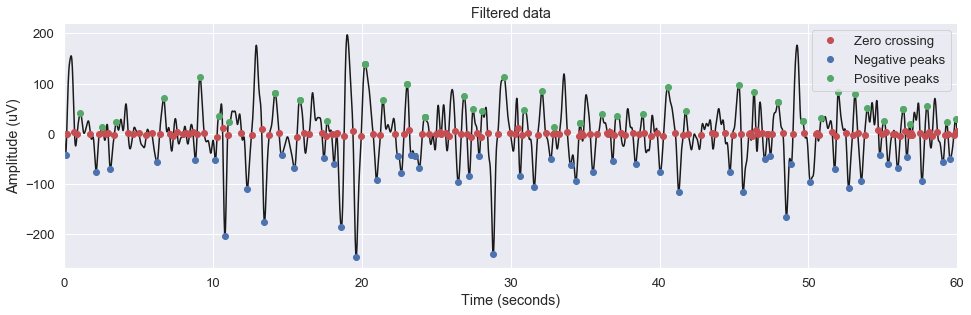

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4.5))
plt.plot(times, data_filt, lw=1.5, color='k')
plt.plot(times[zero_crossings], data_filt[zero_crossings], 'ro', label='Zero crossing')
plt.plot(times[idx_neg_peaks], data_filt[idx_neg_peaks], 'bo', label='Negative peaks')
plt.plot(times[idx_pos_peaks], data_filt[idx_pos_peaks], 'go', label='Positive peaks')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([times.min(), times.max()])
plt.title('Filtered data')
plt.legend()
sns.despine()

In [13]:
# Find distance to previous and following zc
ssorted = np.searchsorted(zero_crossings, idx_neg_peaks)
previous_neg_zc = zero_crossings[ssorted - 1] - idx_neg_peaks
following_neg_zc = zero_crossings[ssorted] - idx_neg_peaks
neg_phase_dur = (abs(previous_neg_zc) + following_neg_zc) / sf

print(previous_neg_zc)
print(following_neg_zc)
print(neg_phase_dur)

[  -8  -39  -16  -34  -16  -75  -16  -40  -19  -18 -104  -14  -16  -31
  -22  -23  -16  -40  -12  -37  -67  -20  -16  -13  -38  -13  -40  -34
  -22  -57  -18  -15  -19  -21  -24  -36  -15  -16  -15  -23  -55  -40
  -16  -20  -25  -10  -16  -20  -12  -14  -36  -16]
[  8  21  26  18  12  11  18  28  33 103  17  12  16  19  34  26  41  17
  75  50  20  20  14   9  31  13  23  17  55  20  25  12  25  21  30  18
  38  17  12  44  12  39  11  26  21  13  29  17  11  18  16  24]
[0.16 0.6  0.42 0.52 0.28 0.86 0.34 0.68 0.52 1.21 1.21 0.26 0.32 0.5
 0.56 0.49 0.57 0.57 0.87 0.87 0.87 0.4  0.3  0.22 0.69 0.26 0.63 0.51
 0.77 0.77 0.43 0.27 0.44 0.42 0.54 0.54 0.53 0.33 0.27 0.67 0.67 0.79
 0.27 0.46 0.46 0.23 0.45 0.37 0.23 0.32 0.52 0.4 ]


In [14]:
# Find distance to previous and following zc
ssorted = np.searchsorted(zero_crossings, idx_pos_peaks)
previous_pos_zc = zero_crossings[ssorted - 1] - idx_pos_peaks
following_pos_zc = zero_crossings[ssorted] - idx_pos_peaks
pos_phase_dur = (abs(previous_pos_zc) + following_pos_zc) / sf

print(previous_pos_zc)
print(following_pos_zc)
print(pos_phase_dur)

[-22 -20 -14 -27 -20 -13  -7 -38 -38 -18 -18 -10 -26 -26 -26 -17 -22 -22
 -15 -15 -15 -20 -12 -12 -41 -14 -29  -7  -9  -9 -34 -16 -21 -27 -15 -41
 -15 -38 -38 -65 -65 -13 -14 -17 -19 -16 -21 -21  -8 -16  -9 -12]
[67  9 79 41 28 24 86 26 26 27 27 29 54 54 54 84 15 15 31 31 31 18 28 35
 43 28 24  7  9  9 37 27 12 52 18 16 12 34 34 12 12 73 49 18 74 11 12 12
  8 15  9  9]
[0.89 0.29 0.93 0.68 0.48 0.37 0.93 0.64 0.64 0.45 0.45 0.39 0.8  0.8
 0.8  1.01 0.37 0.37 0.46 0.46 0.46 0.38 0.4  0.47 0.84 0.42 0.53 0.14
 0.18 0.18 0.71 0.43 0.33 0.79 0.33 0.57 0.27 0.72 0.72 0.77 0.77 0.86
 0.63 0.35 0.93 0.27 0.33 0.33 0.16 0.31 0.18 0.21]


In [15]:
# Define start and end
sw_start = times[idx_neg_peaks + previous_neg_zc]
sw_end = times[idx_pos_peaks + following_pos_zc]
sw_dur = sw_end - sw_start  # Same as pos_phase_dur + neg_phase_dur
sw_midcrossing = times[idx_neg_peaks + following_neg_zc]
sw_idx_neg, sw_idx_pos = times[idx_neg_peaks], times[idx_pos_peaks]
sw_slope = sw_ptp / (sw_midcrossing - sw_idx_neg)  # Slope between peak trough and midcrossing

In [16]:
hypno[idx_neg_peaks + previous_neg_zc]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3])

In [17]:
# Finally we apply a set of thresholds to remove bad slow waves
good_sw = np.logical_and.reduce((previous_neg_zc != 0, 
                                 following_neg_zc != 0,
                                 previous_pos_zc != 0, 
                                 following_pos_zc != 0,
                                 neg_phase_dur > 0.125, 
                                 neg_phase_dur < 1.5,
                                 pos_phase_dur < 1, 
                                 sw_midcrossing > sw_start,
                                 sw_midcrossing < sw_end, 
                                 good_ptp
                                ))
good_sw

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True, False,  True,  True,  True])

In [18]:
# Create the dataframe
sw = pd.DataFrame({'Start': sw_start,
                   'NegPeak': sw_idx_neg,
                   'MidCrossing': sw_midcrossing,
                   'PosPeak': sw_idx_pos,  
                   'End': sw_end, 
                   'Duration': sw_dur,
                   'ValNegPeak': data_filt[idx_neg_peaks], 
                   'ValPosPeak': data_filt[idx_pos_peaks], 
                   'PTP': sw_ptp, 
                   'Slope': sw_slope, 
                   'Frequency': 1 / sw_dur,
                    })[good_sw]

# Remove all duplicates and reset index
sw.drop_duplicates(subset=['Start'], inplace=True, keep=False)
sw.drop_duplicates(subset=['End'], inplace=True, keep=False)
sw.reset_index(drop=True, inplace=True)
sw.round(3)

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency
0,0.00,0.08,0.16,1.08,1.75,1.75,-41.766,41.388,83.154,1039.421,0.571
1,1.75,2.14,2.35,2.55,2.64,0.89,-75.690,14.208,89.898,428.087,1.124
2,2.94,3.10,3.36,3.50,4.29,1.35,-70.861,22.566,93.427,359.335,0.741
3,5.88,6.22,6.40,6.67,7.08,1.20,-57.000,71.326,128.326,712.924,0.833
4,8.64,8.80,8.92,9.12,9.40,0.76,-51.620,113.623,165.243,1377.024,1.316
5,9.40,10.15,10.26,10.39,10.63,1.23,-51.737,34.499,86.236,783.964,0.813
6,10.63,10.79,10.97,11.04,11.90,1.27,-204.698,23.719,228.417,1268.986,0.787
7,26.27,26.47,26.67,26.87,27.05,0.78,-96.542,75.371,171.913,859.567,1.282
8,27.05,27.21,27.35,27.47,27.75,0.70,-83.390,48.677,132.067,943.337,1.429
9,27.75,27.88,27.97,28.09,28.44,0.69,-44.072,45.754,89.826,998.070,1.449


**********************

### Bonus: compute the delta power

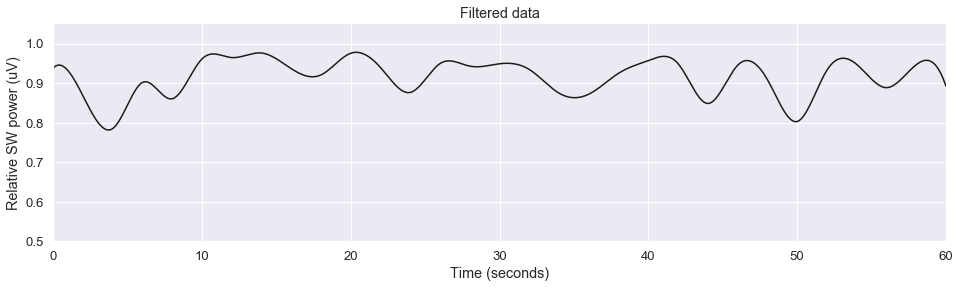

In [19]:
from scipy.interpolate import interp1d

# Compute the pointwise relative power using interpolated STFT
# Here we use a step of 200 ms to speed up the computation.
f, t, Sxx = yasa.main.stft_power(data, sf, window=5, step=2, interp=False, norm=True)
idx_sw = np.logical_and(f >= 0.5, f <= 3.5)
sw_rel_pow = Sxx[idx_sw].sum(0)

# Let's interpolate `rel_pow` to get one value per sample
# Note that we could also have use the `interp=True` in the `stft_power`
# function, however 2D interpolation is much slower than
# 1D interpolation.
func = interp1d(t, sw_rel_pow, kind='cubic', bounds_error=False,
                fill_value=0)
t = np.arange(data.size) / sf
sw_rel_pow = func(t)

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(times, sw_rel_pow, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Relative SW power (uV)')
plt.xlim([times.min(), times.max()])
plt.ylim(0.5, 1.05)
plt.title('Filtered data')
sns.despine()